Руководство компании обеспокоено высокой текучестью кадров, поэтому отделу кадров необходимо разработать систему для снижения количества уволившихся сотрудников. Нам предоставили набор данных с информацией о работниках за последние 24 месяца.

**Цель:** разработка рекомендаций для снижения текучести кадров в компании.

**Задачи:**
 - определить коэффициент текучести кадров в общем и отдельно по департаментам.
 - оценить влияние уровня удовлетворенности и оценок за аттестации на вероятность увольнения.
 - определить, влияют ли повышение и выплата бонусов на вероятность увольнения.

Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import scipy.stats 

Загружаем датасет, смотрим на первые строки, информацию о типах данных, проверяем, есть ли пропущенные значения.

In [2]:
empls = pd.read_csv('employee_churn_data.csv')
empls.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


In [3]:
empls.replace(['low', 'medium', 'high', 'no', 'yes'], [0, 0.5, 1, 0, 1], inplace=True)
empls.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,0.0,5.0,0.626759,0,180.866070,0
1,operations,0,0.751900,3,0.5,6.0,0.443679,0,182.708149,0
2,support,0,0.722548,3,0.5,6.0,0.446823,0,184.416084,0
3,logistics,0,0.675158,4,1.0,8.0,0.440139,0,188.707545,0
4,sales,0,0.676203,3,1.0,5.0,0.577607,1,179.821083,0


In [4]:
empls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   float64
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 745.4+ KB


In [5]:
empls.isna().sum()

department       0
promoted         0
review           0
projects         0
salary           0
tenure           0
satisfaction     0
bonus            0
avg_hrs_month    0
left             0
dtype: int64

In [6]:
empls.describe()

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.030294,0.651826,3.274843,0.508753,6.556184,0.504645,0.212055,184.661571,0.291824
std,0.171403,0.085307,0.579136,0.276925,1.415432,0.158555,0.408785,4.144831,0.454626
min,0.000000,0.310000,2.000000,0.000000,2.000000,0.000000,0.000000,171.374060,0.000000
25%,0.000000,0.592884,3.000000,0.500000,5.000000,0.386801,0.000000,181.472085,0.000000
50%,0.000000,0.647456,3.000000,0.500000,7.000000,0.500786,0.000000,184.628796,0.000000
75%,0.000000,0.708379,4.000000,0.500000,8.000000,0.622607,0.000000,187.728708,1.000000
max,1.000000,1.000000,5.000000,1.000000,12.000000,1.000000,1.000000,200.861656,1.000000


Рассчитаем коэффициент текучести кадров для всей компании.

In [7]:
coef = empls['left'].value_counts(normalize=True)[1]
print(f'Коэффициент текучести кадров равен {100 * coef:.2f}%')

Коэффициент текучести кадров равен 29.18%


В зависимости от отрасли и страны коэффициент текучести кадров ($К_{т}$) колеблется от 3 до 60%. Будем считать премлемым значением 10-15%. В нашей компании он выше 2,5 раза. Следует выяснить, по какой причине работники массово увольняются.
Рассчитаем коэффициент для каждого департамента.

In [8]:
coef_by_dep = empls.groupby('department')['left'].value_counts(normalize=True).unstack()
for col in coef_by_dep.columns:
    coef_by_dep[col] = round(coef_by_dep[col] * 100, 2)
    
coef_by_dep = coef_by_dep.sort_values(1)
coef_by_dep = coef_by_dep.rename(columns={0:'working', 1:'quitted'})
coef_by_dep

left,working,quitted
department,,
finance,73.13,26.87
admin,71.87,28.13
sales,71.48,28.52
operations,71.35,28.65
engineering,71.17,28.83
support,71.16,28.84
marketing,69.70,30.30
retail,69.44,30.56
logistics,69.17,30.83


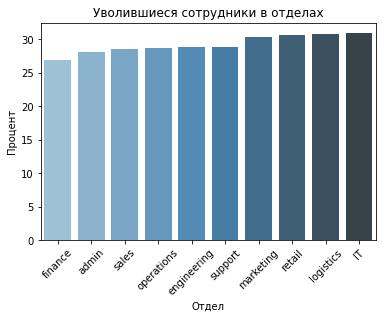

In [9]:
sns.barplot(x='department', y='quitted', data=coef_by_dep.reset_index(), palette='Blues_d')
plt.xticks(rotation=45)
plt.title('Уволившиеся сотрудники в отделах')
plt.ylabel('Процент')
plt.xlabel('Отдел')
plt.show()

Процент уволившихся колеблется между 26.87% и 30.90% для каждого департамента. Самый высокий показатель у IT-подразделения (30.9%), — самый низкий — у отдела finance (26.87%). Можем сделать вывод, что во всех департаментах есть проблемы с кадрами.

Посмотрим на таблицу корреляций.

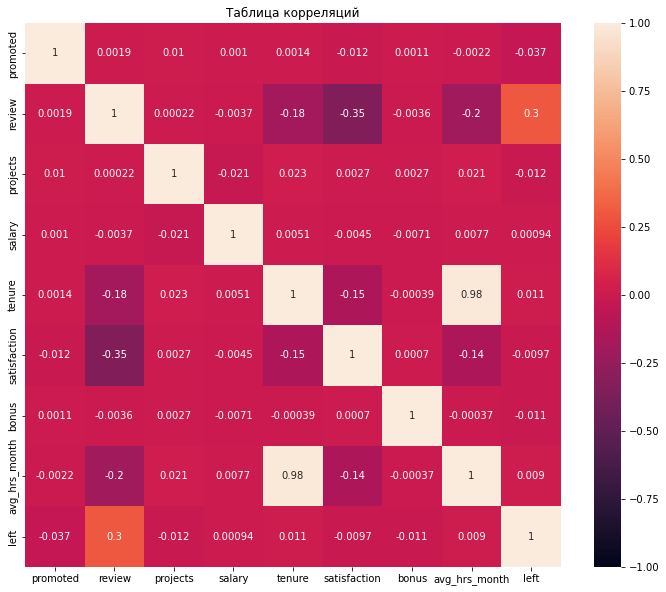

In [10]:
correlation = empls.corr()
fig, ax= plt.subplots(figsize=(12,10))
sns.heatmap(data=correlation, annot=True, vmin=-1, vmax=1)

plt.title('Таблица корреляций')
plt.show()

Заметим, что существуют линейные зависимости между следующими параметрами:
* review и left: слабая положительная связь (0.3)
* satisfaction и review: слабая отрицательная связь (-0.35)
* tenure и avg_hrs_month: очень сильная положительная связь (0.98)

Построим pairplot и попробуем найти какие-нибудь закономерности.

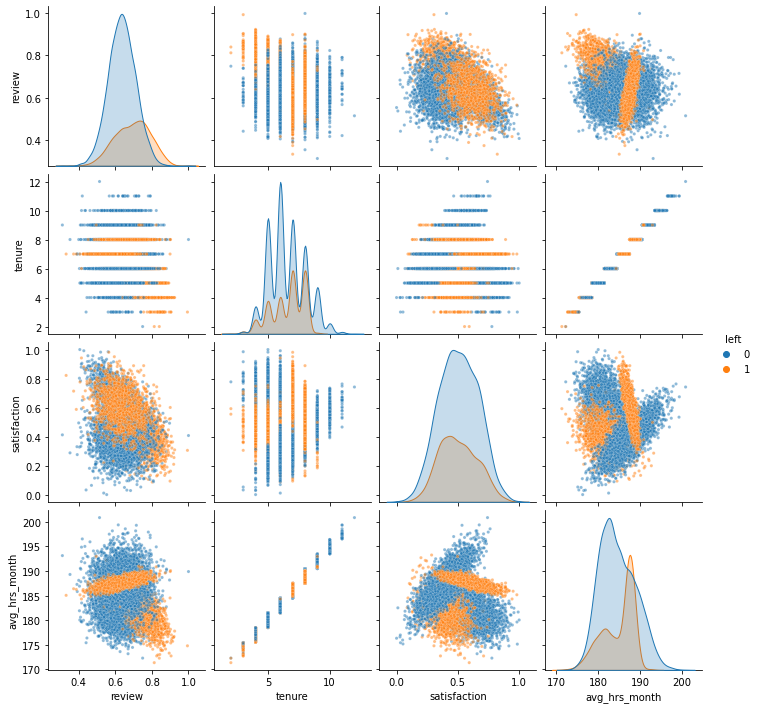

In [11]:
empls_paired = empls[['review', 'tenure', 'satisfaction', 'avg_hrs_month', 'left']]
sns.pairplot(data=empls_paired, hue='left', plot_kws={'alpha':0.5, 's':10})
plt.show()

* Работники с большим стажем отрабатывают больше часов в месяц. 
* Доля уволившихся сотрудников выше в следующих категориях: стаж работы меньше 4 лет и стаж работы от 7 до 8 лет.
* При превышении некоторого среднего числа отработанных часов удовлетворенность уволившихся сотрудников резко снижается. Но здесь также может играть роль сильная корреляция между стажем и кол-вом отработанных часов в месяц.  
* Уволившиеся сотрудники с большей оценкой меньше удовлетворены.

## Влияние стажа работы

Посмотрим, как зависит $К_{т}$  от стажа работы

In [12]:
tenure = empls.groupby('tenure')['left'].value_counts().unstack().replace(np.nan, 0)
tenure.columns = ['working', 'quitted']
tenure

,working,quitted
tenure,,
2.0,1.0,2.0
3.0,27.0,30.0
4.0,332.0,186.0
5.0,1395.0,428.0
6.0,1835.0,478.0
7.0,1386.0,823.0
8.0,1065.0,823.0
9.0,564.0,14.0
10.0,127.0,0.0


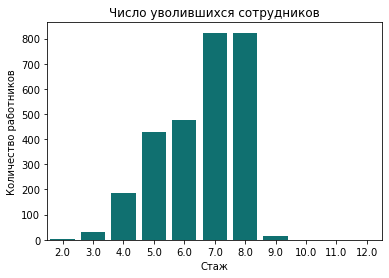

In [13]:
sns.barplot(x='tenure', y='quitted', data=tenure.reset_index(), color='teal')

plt.title('Число уволившихся сотрудников')
plt.xlabel('Стаж')
plt.ylabel('Количество работников')
plt.show()

In [14]:
tenure_norm = empls.groupby('tenure')['left'].value_counts(normalize=True).unstack().replace(np.nan, 0)
tenure_norm.columns = ['working_coeg', 'quitted_coef']
for col in tenure_norm.columns:
    tenure_norm[col] = round(tenure_norm[col] * 100, 2)

print('Коэффициент текучести в зависимости от выслуги лет')
tenure_norm[['quitted_coef']]

Коэффициент текучести в зависимости от выслуги лет


,quitted_coef
tenure,
2.0,66.67
3.0,52.63
4.0,35.91
5.0,23.48
6.0,20.67
7.0,37.26
8.0,43.59
9.0,2.42
10.0,0.00


В первые три года работы увольняется больше половины сотрудников. 
<br>$К_{т}$ снижается среди работников со стажем от четырех до шести лет.
<br>Однако доля уволившихся сотрудников возрастает, когда стаж работы приближается к 7-8 годам.
<br>Сотрудники с наибольшим стажем (9-12 лет) имеют самый низкий коэффициент. 

Рассмотрим, как меняются показатели внутри этих групп

In [15]:
def grades(tenure):
    if tenure <= 3:
        return 'junior'
    elif tenure <= 6:
        return 'middle'
    elif tenure <= 8:
        return 'senior'
    else:
        return 'senior-pomidor'

In [16]:
empls['grade'] = empls['tenure'].apply(grades)

In [17]:
empls.groupby('grade').size()

grade
junior              60
middle            4654
senior            4097
senior-pomidor     729
dtype: int64

In [18]:
grades_coef = round(empls.groupby('grade')['left'].mean() * 100, 2)
grades_coef

grade
junior            53.33
middle            23.46
senior            40.18
senior-pomidor     1.92
Name: left, dtype: float64

In [19]:
grades_coef = empls.groupby('grade')['left'].value_counts(normalize=True).unstack()
grades_coef.columns = ['working_coeg', 'quitted_coef']
for col in grades_coef.columns:
    grades_coef[col] = round(grades_coef[col] * 100, 2)

grades_coef

,working_coeg,quitted_coef
grade,,
junior,46.67,53.33
middle,76.54,23.46
senior,59.82,40.18
senior-pomidor,98.08,1.92


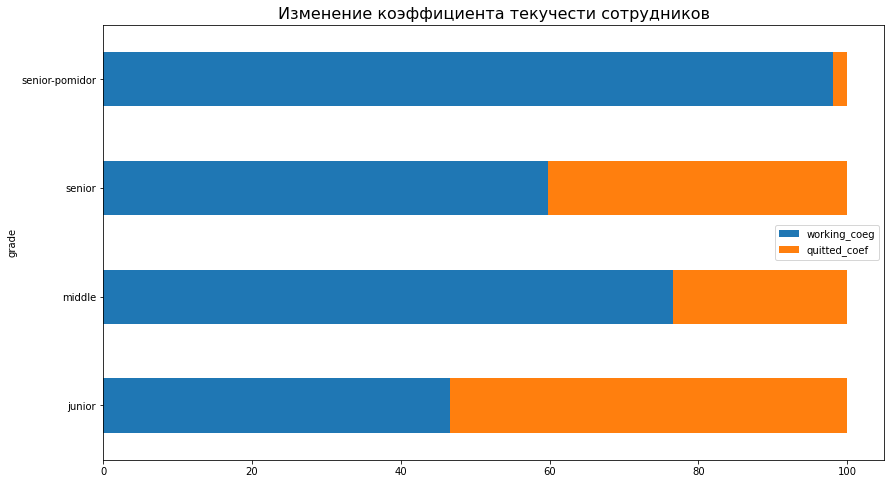

In [20]:
fig, ax = plt.subplots(figsize=(14, 8))
grades_coef.plot(kind='barh', stacked=True, ax=ax)
plt.title('Изменение коэффициента текучести сотрудников', size=16)
plt.show()

In [21]:
junior = empls[empls['grade'] == 'junior']
middle = empls[empls['grade'] == 'middle']
senior = empls[empls['grade'] == 'senior']
senior_pomidor = empls[empls['grade'] == 'senior-pomidor']

In [22]:
def plots_by_grade(data, name):
    fig, ax = plt.subplots(2, figsize=(12,8))
    sns.histplot(x='satisfaction', data=data, hue='left', ax=ax[0], bins=20)
    sns.histplot(x='review', data=data, hue='left', ax=ax[1], bins=20)
    plt.suptitle(f'Распределение параметров satisfaction и review для {name}', size=16)
    plt.show()

In [23]:
def heatmap_by_grade(data):
    heat = data.groupby('left')[['satisfaction', 'review']].mean()
    
    sns.heatmap(heat, annot=True, vmin=0, vmax=1)
    plt.title('Средние значения satisfaction и review')
    plt.show()

## Сотрудники со стажем <4 лет ($К_{т}$ = 53%)

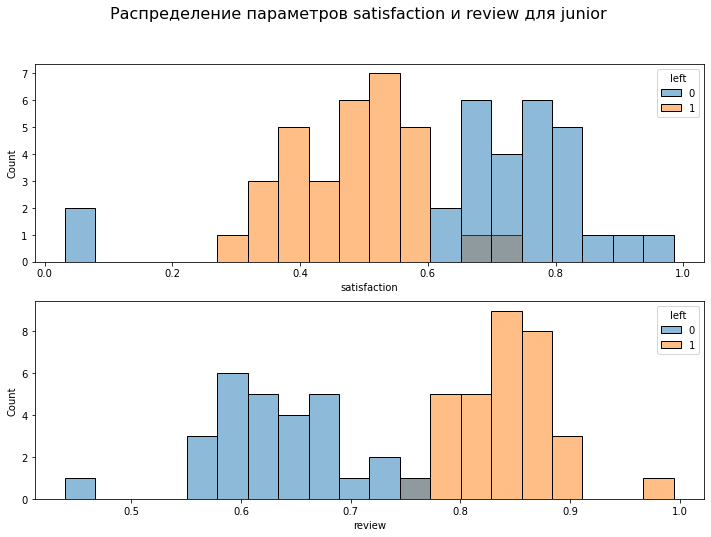

In [24]:
plots_by_grade(junior, 'junior')

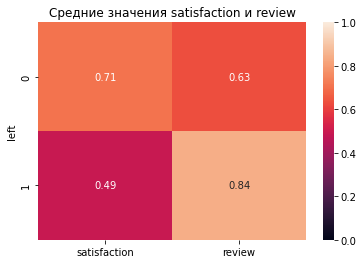

In [25]:
heatmap_by_grade(junior)

In [26]:
params = ['promoted', 'review', 'salary', 'satisfaction', 'bonus']
cont = ['review', 'satisfaction']
nomin = ['promoted', 'salary', 'bonus']

In [27]:
junior.groupby('left')[params].mean()

,promoted,review,salary,satisfaction,bonus
left,,,,,
0,0.035714,0.631720,0.50000,0.706088,0.178571
1,0.031250,0.841631,0.53125,0.489846,0.156250


In [28]:
junior['left'].value_counts()

1    32
0    28
Name: left, dtype: int64

Поскольку размеры выборок малы, воспользуемся критерием Манна-Уитни (review, satisfaction).
Для параметров bonus и promoted будем использовать точный критерий Фишера.
<br>Нулевая гипотеза: средние satisfaction для двух групп одинаковы. Альтернативная: $\overline{s}_L - \overline{s}_W < 0$.
Уровень статистической значимости примем 0.05.
<br>Нулевая гипотеза: средние review для двух групп одинаковы. Альтернативная: $\overline{r}_L- \overline{r}_W > 0$.
Уровень статистической значимости примем 0.05.

In [29]:
def check_hyp(p_value, a=0.05):
    if p_value <= a:
        print('Отклоняем нулевую гипотезу')
    else:
        print('Не удалось отклонить нулевую гипотезу')

In [30]:
def mwu_sat_rev(data, alts):
    left = data[data['left'] == 1]
    work = data[data['left'] == 0]
    for column, alt in alts.items():
        s = pg.mwu(left[column], work[column], alternative=alt)
        display(s)
        p_val = s['p-val'][0]
        print(f'p-value для параметра {column} = {p_val}')
        check_hyp(p_val)

In [31]:
mwu_sat_rev(junior, {'satisfaction':'less', 'review':'greater'})

,U-val,alternative,p-val,RBC,CLES
MWU,81.0,less,2.808665e-08,0.819196,0.909598


p-value для параметра satisfaction = 2.8086651029210444e-08
Отклоняем нулевую гипотезу


,U-val,alternative,p-val,RBC,CLES
MWU,896.0,greater,1.669567e-11,-1.0,1.0


p-value для параметра review = 1.669567052687147e-11
Отклоняем нулевую гипотезу


Нулевая гипотеза: распределения не отличаются от ожидаемых. Альтернативная гипотеза: распределение зависит от того, к какой группе принадлежит работник. Уровень статистической значимости = 0.05

In [32]:
def fisher(data, *args):
    for column in args:
        df = data.groupby('left')[column].value_counts().unstack().replace(np.nan, 0)
        display(df)
        oddsr, p = scipy.stats.fisher_exact(df)
        print(f'p-value для параметра {column} = {p}')
        check_hyp(p)

In [33]:
fisher(junior, 'bonus', 'promoted')

bonus,0,1
left,,
0,23,5
1,27,5


p-value для параметра bonus = 1.0
Не удалось отклонить нулевую гипотезу


promoted,0,1
left,,
0,27,1
1,31,1


p-value для параметра promoted = 1.0
Не удалось отклонить нулевую гипотезу


Отклоняем нулевую гипотезу для двух критериев: satisfaction и review. В остальных случаях отвергнуть нулевую гипотезу нельзя.
<br>**Вывод:** Начинающие специалисты увольняются, если их уровень удовлетворенности низкий, повышения и бонусы не оказывают такого влияния. При этом средняя оценка уволившихся новичков выше, чем у оставшихся в компании. Можем предположить, что для получения более высокого балла работнику приходится прикладывать намного больше усилий, что сказывается на желании продолжать сотрудничать с компанией.

## Сотрудники со стажем 4-6 лет ($К_{т}$ = 23%)

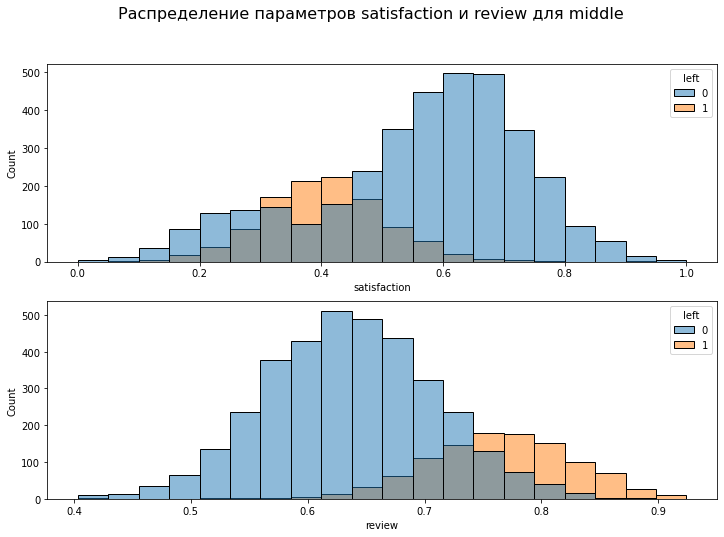

In [34]:
plots_by_grade(middle, 'middle')

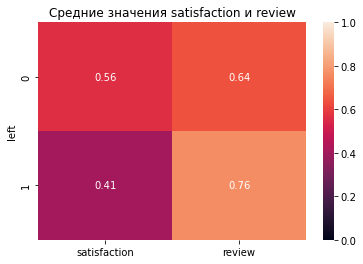

In [35]:
heatmap_by_grade(middle)

In [36]:
middle.groupby('left')[params].mean()

,promoted,review,salary,satisfaction,bonus
left,,,,,
0,0.036496,0.636768,0.507019,0.562241,0.212240
1,0.020147,0.764638,0.513278,0.405082,0.200549


In [37]:
middle['left'].value_counts()

0    3562
1    1092
Name: left, dtype: int64

In [38]:
for col in nomin:
    display(middle.groupby('left')[col].value_counts().unstack())

promoted,0,1
left,,
0,3432,130
1,1070,22


salary,0.0,0.5,1.0
left,,,
0,523,2466,573
1,150,763,179


bonus,0,1
left,,
0,2806,756
1,873,219


Поскольку объем выборок достаточно велик, можем проверить наши гипотезы с помощью t-test и критерия хи-квадрат.
<br>Нулевая гипотеза: средние satisfaction для двух групп одинаковы. Альтернативная: $\overline{s}_L - \overline{s}_W < 0$.
<br>Нулевая гипотеза: средние review для двух групп одинаковы. Альтернативная: $\overline{r}_L - \overline{r}_W > 0$.
Уровень статистической значимости в обоих случаях примем 0.05

In [39]:
def ttests_sat_rev(data, alts):
    left = data[data['left'] == 1]
    work = data[data['left'] == 0]
    for column, alt in alts.items():
        st, p = scipy.stats.ttest_ind(left[column], work[column], alternative = alt)
        print(f'p-value для параметра {column} = {p}')
        check_hyp(p)

In [40]:
ttests_sat_rev(middle, {'satisfaction':'less', 'review':'greater'})

p-value для параметра satisfaction = 1.2908432987129605e-164
Отклоняем нулевую гипотезу
p-value для параметра review = 0.0
Отклоняем нулевую гипотезу


Нулевая гипотеза: распределения не отличаются от ожидаемых. Альтернативная гипотеза: распределение зависит от того, к какой группе принадлежит работник. Уровень статистической значимости = 0.05

In [41]:
def chi(data, *args):
    for column in args:
        df = data.groupby('left')[column].value_counts().unstack()
        display(df)
        chi2, p, dof, ex = scipy.stats.chi2_contingency(df)
        print(f'p-value для параметра {column} = {p}')
        check_hyp(p)

In [42]:
chi(middle, 'promoted', 'salary', 'bonus')

promoted,0,1
left,,
0,3432,130
1,1070,22


p-value для параметра promoted = 0.010408539014600775
Отклоняем нулевую гипотезу


salary,0.0,0.5,1.0
left,,,
0,523,2466,573
1,150,763,179


p-value для параметра salary = 0.7350838860162336
Не удалось отклонить нулевую гипотезу


bonus,0,1
left,,
0,2806,756
1,873,219


p-value для параметра bonus = 0.43068386578618245
Не удалось отклонить нулевую гипотезу


**Вывод:** Сотрудники со стажем 4-6 лет увольняются, если их уровень удовлетворенности низкий. При этом их оценка, как и у начинающих работников, в среднем выше. Поэтому для этой группы также можем предположить, что для получения более высокого балла работнику приходится прикладывать намного больше усилий, что сказывается на желании продолжать сотрудничать с компанией.
При отсутствии повышения они также склонны к тому, чтобы покинуть компанию.

## Сотрудники со стажем 7-8 лет ($K_т$ = 40%)

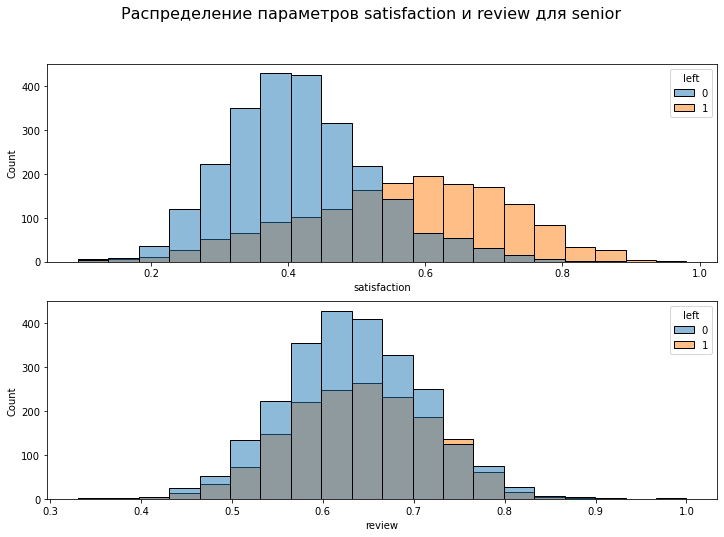

In [43]:
plots_by_grade(senior, 'senior')

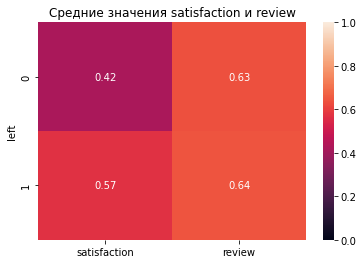

In [44]:
heatmap_by_grade(senior)

In [45]:
senior.groupby('left')[params].mean()

,promoted,review,salary,satisfaction,bonus
left,,,,,
0,0.028968,0.633392,0.505304,0.41827,0.223174
1,0.020656,0.641588,0.506379,0.56872,0.208384


In [46]:
senior['left'].value_counts()

0    2451
1    1646
Name: left, dtype: int64

In [47]:
for col in nomin:
    display(senior.groupby('left')[col].value_counts().unstack())

promoted,0,1
left,,
0,2380,71
1,1612,34


salary,0.0,0.5,1.0
left,,,
0,360,1705,386
1,235,1155,256


bonus,0,1
left,,
0,1904,547
1,1303,343


In [48]:
ttests_sat_rev(senior, {'satisfaction':'greater', 'review':'greater'})

p-value для параметра satisfaction = 3.6693911176519304e-264
Отклоняем нулевую гипотезу
p-value для параметра review = 0.00045387845361528526
Отклоняем нулевую гипотезу


Нулевая гипотеза: распределения не отличаются от ожидаемых. Альтернативная гипотеза: распределение зависит от того, к какой группе принадлежит работник. Уровень статистической значимости = 0.05

In [49]:
chi(senior, 'promoted', 'salary', 'bonus')

promoted,0,1
left,,
0,2380,71
1,1612,34


p-value для параметра promoted = 0.12122050566762853
Не удалось отклонить нулевую гипотезу


salary,0.0,0.5,1.0
left,,,
0,360,1705,386
1,235,1155,256


p-value для параметра salary = 0.9091624550116421
Не удалось отклонить нулевую гипотезу


bonus,0,1
left,,
0,1904,547
1,1303,343


p-value для параметра bonus = 0.2770927743448929
Не удалось отклонить нулевую гипотезу


Уволившиеся сотрудники в среднем были больше удовлетворены, чем оставшиеся работники. Их оценки также были выше, а различия в бонусах, повышениях и размерах зарплаты для этих двух групп не являются статистически значимыми.
<br>Попробуем рассмотреть внутри этой группы каждый год работы в отдельности.

In [50]:
seven_years = senior[senior['tenure'] == 7]
print(f"Коэффициент текучести для работников со стажем 7 лет = {100 * seven_years['left'].mean():.2f}%")

Коэффициент текучести для работников со стажем 7 лет = 37.26%


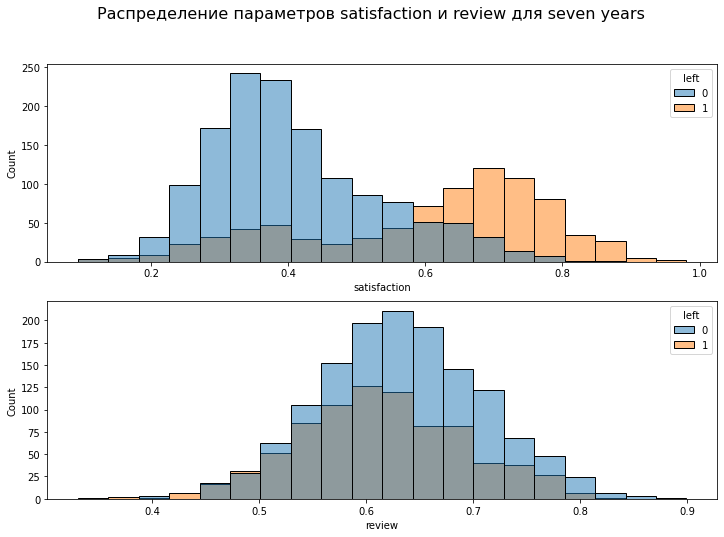

In [51]:
plots_by_grade(seven_years, 'seven years')

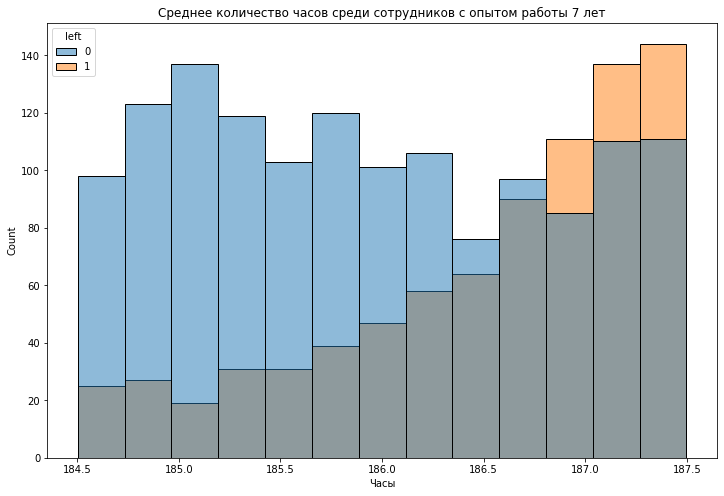

In [52]:
plt.figure(figsize=(12,8))
sns.histplot(x='avg_hrs_month', data=seven_years, hue='left')
plt.xlabel('Часы')
plt.title('Среднее количество часов среди сотрудников с опытом работы 7 лет')
plt.show()

In [53]:
seven_years.groupby('left').mean()

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month
left,,,,,,,,
0,0.028860,0.63379,3.291486,0.504329,7.0,0.408793,0.227273,185.944884
1,0.020656,0.61453,3.243013,0.518226,7.0,0.604135,0.221142,186.531262


<br>Нулевая гипотеза: средние satisfaction для двух групп одинаковы. Альтернативная: $\overline{s}_L - \overline{s}_W > 0$.
<br>Нулевая гипотеза: средние review для двух групп одинаковы. Альтернативная: $\overline{r}_L - \overline{r}_W < 0$.
<br>Нулевая гипотеза: средние avg_hrs_month для двух групп одинаковы. Альтернативная: $\overline{h}_L - \overline{h}_W > 0$.
Уровень статистической значимости во всех гипотезах 0.05

In [54]:
ttests_sat_rev(seven_years, {'satisfaction':'greater', 'review':'less', 'avg_hrs_month':'greater'})

p-value для параметра satisfaction = 1.024466675786222e-170
Отклоняем нулевую гипотезу
p-value для параметра review = 7.1001557418110475e-09
Отклоняем нулевую гипотезу
p-value для параметра avg_hrs_month = 3.974835310072238e-54
Отклоняем нулевую гипотезу


In [55]:
for col in nomin:
    display(seven_years.groupby('left')[col].value_counts().unstack())

promoted,0,1
left,,
0,1346,40
1,806,17


salary,0.0,0.5,1.0
left,,,
0,209,956,221
1,104,585,134


bonus,0,1
left,,
0,1071,315
1,641,182


In [56]:
chi(seven_years, 'promoted', 'salary', 'bonus', 'projects')

promoted,0,1
left,,
0,1346,40
1,806,17


p-value для параметра promoted = 0.29971675792310715
Не удалось отклонить нулевую гипотезу


salary,0.0,0.5,1.0
left,,,
0,209,956,221
1,104,585,134


p-value для параметра salary = 0.2809490362902543
Не удалось отклонить нулевую гипотезу


bonus,0,1
left,,
0,1071,315
1,641,182


p-value для параметра bonus = 0.7787676570725047
Не удалось отклонить нулевую гипотезу


projects,2,3,4,5
left,,,,
0,79,834,463,10
1,54,521,242,6


p-value для параметра projects = 0.25584711041931696
Не удалось отклонить нулевую гипотезу


Работники с опытом работы 7 лет, решившие покинуть компанию имеют больший уровень удовлетворенности, однако их средняя оценка ниже. Также они отрабатывают больше часов в месяц.
<br>Компании следует отслеживать количество отработанных часов для снижения риска увольнения сотрудников.

In [57]:
eight_years = senior[senior['tenure'] == 8]
print(f"Коэффициент текучести для работников со стажем 8 лет = {100 * eight_years['left'].mean():.2f}%")

Коэффициент текучести для работников со стажем 8 лет = 43.59%


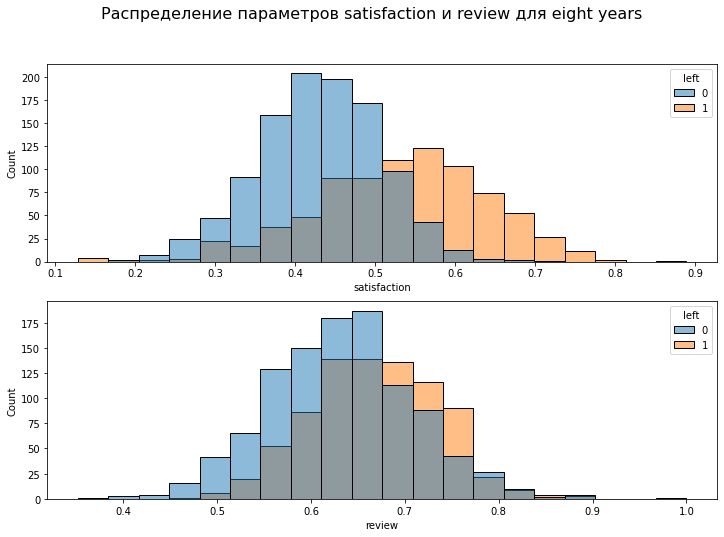

In [58]:
plots_by_grade(eight_years, 'eight years')

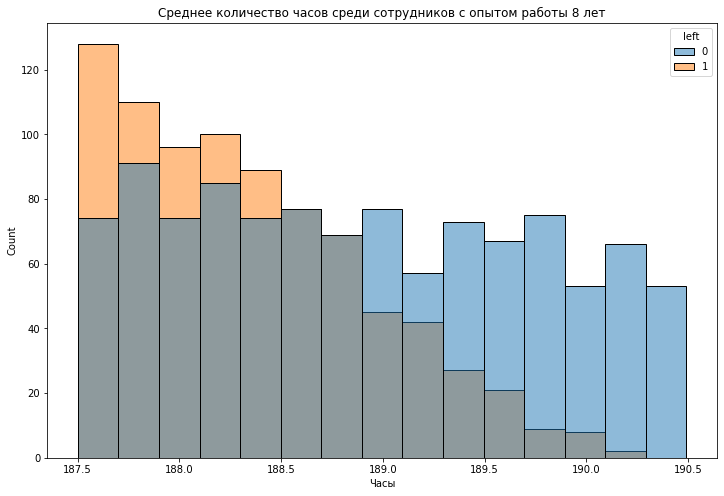

In [59]:
plt.figure(figsize=(12,8))
sns.histplot(x='avg_hrs_month', data=eight_years, hue='left')
plt.xlabel('Часы')
plt.title('Среднее количество часов среди сотрудников с опытом работы 8 лет')
plt.show()

In [60]:
eight_years.groupby('left').mean()

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month
left,,,,,,,,
0,0.029108,0.632873,3.284507,0.506573,8.0,0.430604,0.217840,188.905219
1,0.020656,0.668647,3.268530,0.494532,8.0,0.533306,0.195626,188.343330


<br>Нулевая гипотеза: средние satisfaction для двух групп одинаковы. Альтернативная: $\overline{s}_L - \overline{s}_W > 0$.
<br>Нулевая гипотеза: средние review для двух групп одинаковы. Альтернативная: $\overline{r}_L - \overline{r}_W > 0$.
<br>Нулевая гипотеза: средние avg_hrs_month для двух групп одинаковы. Альтернативная: $\overline{h}_L - \overline{h}_W < 0$.
Уровень статистической значимости во всех гипотезах 0.05

In [61]:
ttests_sat_rev(eight_years, {'satisfaction':'greater', 'review':'greater', 'avg_hrs_month':'less'})

p-value для параметра satisfaction = 5.180949533074003e-112
Отклоняем нулевую гипотезу
p-value для параметра review = 4.80490756654856e-25
Отклоняем нулевую гипотезу
p-value для параметра avg_hrs_month = 8.590629167872119e-55
Отклоняем нулевую гипотезу


In [62]:
for col in nomin:
    display(eight_years.groupby('left')[col].value_counts().unstack())

promoted,0,1
left,,
0,1034,31
1,806,17


salary,0.0,0.5,1.0
left,,,
0,151,749,165
1,131,570,122


bonus,0,1
left,,
0,833,232
1,662,161


In [63]:
chi(eight_years, 'promoted', 'salary', 'bonus', 'projects')

promoted,0,1
left,,
0,1034,31
1,806,17


p-value для параметра promoted = 0.3127440740989415
Не удалось отклонить нулевую гипотезу


salary,0.0,0.5,1.0
left,,,
0,151,749,165
1,131,570,122


p-value для параметра salary = 0.561943783291728
Не удалось отклонить нулевую гипотезу


bonus,0,1
left,,
0,833,232
1,662,161


p-value для параметра bonus = 0.26194851026028876
Не удалось отклонить нулевую гипотезу


projects,2,3,4,5
left,,,,
0,55,659,344,7
1,52,502,265,4


p-value для параметра projects = 0.7091108917453042
Не удалось отклонить нулевую гипотезу


Ушедшие сотрудники с опытом работы 8 лет в среднем получают более высокий балл за аттестацию и имеют больший уровень удовлетворения при меньшем количестве отработанных часов в месяц. 
<br> **Вывод:** По имеющимся данным не удалось выяснить, по какой причине в этой группе $К_т$ такой высокий.
Т.к. большая часть уволившихся сотрудников имеют стаж 7-8 лет, необходимо дополнить наши данные и определить, какие еще параметры могут объяснить нам такой высокий коэффциент текучести (например, пол работника, его возраст, частые переработки, расширенные переменные salary и  satisfaction, взаимоотношения внутри коллектива и с руководством, последний уход в отпуск, наличие удаленного формата работы, семейное положение, наличие детей и др.)

## Сотрудники со стажем 9+ лет ($K_т$ = 2%)

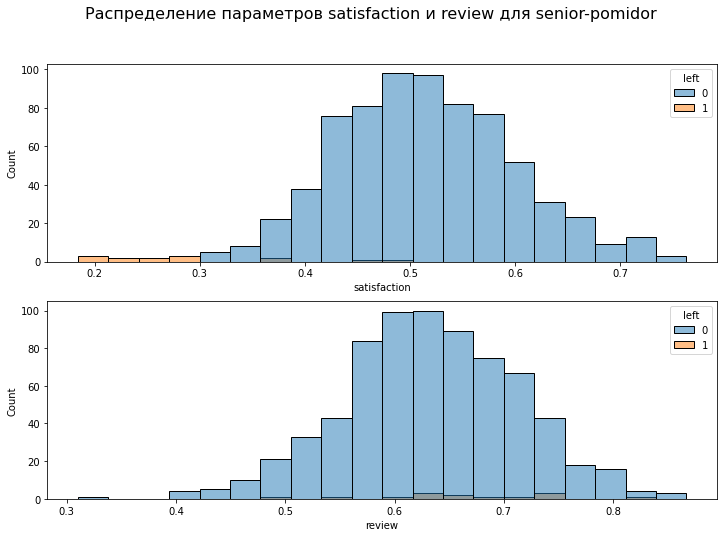

In [64]:
plots_by_grade(senior_pomidor, 'senior-pomidor')

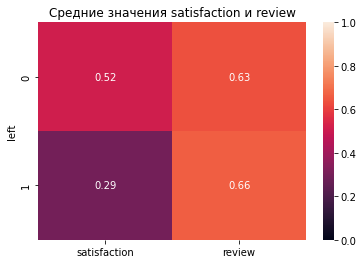

In [65]:
heatmap_by_grade(senior_pomidor)

In [66]:
senior_pomidor.groupby('left').mean()

,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month
left,,,,,,,,
0,0.041958,0.633379,3.324476,0.527972,9.246154,0.515260,0.202797,192.425734
1,0.000000,0.663276,3.071429,0.464286,9.000000,0.293466,0.214286,191.594086


In [67]:
senior_pomidor['left'].value_counts()

0    715
1     14
Name: left, dtype: int64

In [68]:
for col in nomin:
    display(senior_pomidor.groupby('left')[col].value_counts().unstack())

promoted,0,1
left,,
0,685.0,30.0
1,14.0,NaN


salary,0.0,0.5,1.0
left,,,
0,102,471,142
1,3,9,2


bonus,0,1
left,,
0,570,145
1,11,3


Воспользуемся критерием Манна-Уитни (review, satisfaction).
Для параметров bonus и promoted будем использовать точный критерий Фишера.
<br>Нулевая гипотеза: средние satisfaction для двух групп одинаковы. Альтернативная: $\overline{s}_L - \overline{s}_W < 0$.
Уровень статистической значимости примем 0.05.
<br>Нулевая гипотеза: средние review для двух групп одинаковы. Альтернативная: $\overline{r}_L- \overline{r}_W > 0$.
Уровень статистической значимости примем 0.05.

In [69]:
mwu_sat_rev(senior_pomidor, {'satisfaction':'less', 'review':'greater'})

,U-val,alternative,p-val,RBC,CLES
MWU,563.0,less,6.289123e-09,0.887512,0.943756


p-value для параметра satisfaction = 6.289122585799481e-09
Отклоняем нулевую гипотезу


,U-val,alternative,p-val,RBC,CLES
MWU,6058.0,greater,0.088707,-0.21039,0.605195


p-value для параметра review = 0.08870724227657545
Не удалось отклонить нулевую гипотезу


Нулевая гипотеза: распределения не отличаются от ожидаемых. Альтернативная гипотеза: распределение зависит от того, к какой группе принадлежит работник. Уровень статистической значимости = 0.05

In [70]:
fisher(senior_pomidor, 'promoted', 'bonus')

promoted,0,1
left,,
0,685.0,30.0
1,14.0,0.0


p-value для параметра promoted = 1.0
Не удалось отклонить нулевую гипотезу


bonus,0,1
left,,
0,570,145
1,11,3


p-value для параметра bonus = 1.0
Не удалось отклонить нулевую гипотезу


**Вывод:** Наиболее опытные сотрудники увольняются в случае, когда их уровень удовлетворенности очень низкий, если уровень удовлетворения средний и выше, то с большой долей вероятности они останутся в компании и дальше.

## Анализ $К_т$ по отделам и стажу работы

Найдем количество уволившихся сотрудников в каждом отделе для каждого грейда

In [71]:
left_by_dep_grade = empls.groupby(['department', 'grade'])['left'].sum().unstack()
left_by_dep_grade

grade,junior,middle,senior,senior-pomidor
department,,,,
IT,1,41,67,1
admin,4,35,79,1
engineering,2,174,260,1
finance,0,46,59,3
logistics,4,46,61,0
marketing,3,106,132,2
operations,1,174,260,1
retail,6,178,283,4
sales,8,214,314,1


Рассчитаем для них $К_т$ и построим график

In [72]:
grades_dep_coef = empls.groupby(['department', 'grade'])['left'].mean().unstack()
for col in grades_dep_coef.columns:
    grades_dep_coef[col] = round(grades_dep_coef[col] * 100, 2)

grades_dep_coef

grade,junior,middle,senior,senior-pomidor
department,,,,
IT,50.00,24.40,42.41,3.57
admin,66.67,16.59,45.93,2.94
engineering,25.00,23.74,39.16,0.90
finance,0.00,22.01,34.71,13.64
logistics,80.00,26.29,40.13,0.00
marketing,50.00,25.98,40.12,3.39
operations,25.00,24.00,38.92,0.80
retail,66.67,23.70,42.75,3.36
sales,57.14,23.19,39.30,0.68


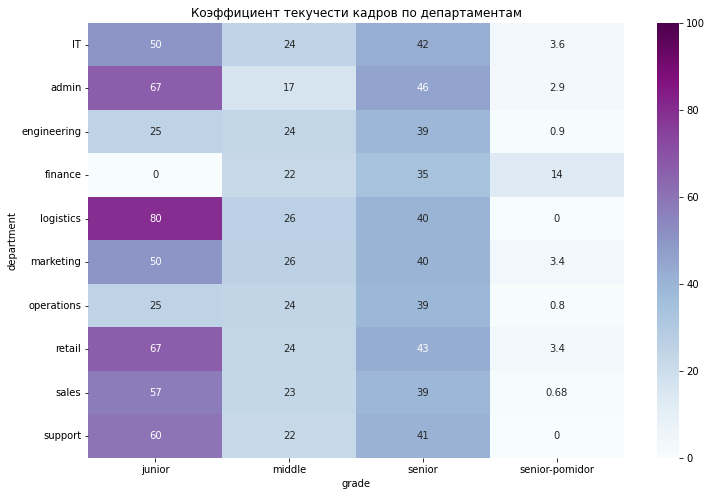

In [73]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(grades_dep_coef, vmin=0, vmax=100, annot=True, cmap='BuPu')
plt.title('Коэффициент текучести кадров по департаментам')
plt.show()

Работа по снижению текучести кадров должна проводиться во всех отделах, т.к. низкие значения $К_т$ встречаются намного реже.

## Выводы


Начинающие специалисты увольняются, если их уровень удовлетворенности низкий, повышения и бонусы не оказывают такого влияния. При этом средняя оценка уволившихся новичков выше, чем у оставшихся в компании. Можем предположить, что для получения более высокого балла работнику приходится прикладывать намного больше усилий, что сказывается на желании продолжать сотрудничать с компанией. 
<br> Сотрудники со стажем 4-6 лет увольняются, если их уровень удовлетворенности низкий. При этом их оценка, как и у начинающих работников, в среднем выше. При отсутствии повышения они также склонны к тому, чтобы покинуть компанию.
<br>Работники с опытом работы 7 лет, решившие покинуть компанию имеют больший уровень удовлетворенности, однако их средняя оценка ниже. Также они отрабатывают больше часов в месяц.
<br>Ушедшие сотрудники с опытом работы 8 лет в среднем получают более высокий балл за аттестацию и имеют больший уровень удовлетворения при меньшем количестве отработанных часов в месяц. По имеющимся данным не удалось выяснить, по какой причине они решают уволиться, поэтому необходимо дополнить имеющиеся данные.
<br>Наиболее опытные сотрудники увольняются в случае, когда их уровень удовлетворенности очеь низок, если уровень удовлетворения средний и выше, то с большой долей вероятности они останутся в компании и дальше.

Компании следует отслеживать уровень удовлетворенности и стараться повышать его среди всех сотрудников (своевременно реагировать на обратную связь, повышать лояльность коллектива, улучшать обстановку внутри отделов и т.д.), проработать систему повышений сотрудников (особенно для работников со стажем 4-6 лет), контролировать количество отработанных часов в месяц. 
<br>Работа по снижению текучести кадров должна проводиться во всех отделах.